In [1]:
import os 
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-8ab9a0c8-909c-3f13-97e6-7376d6d4a029/0/0"

In [2]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics, ToUnknown
from pytorch_ood.dataset.img import Textures
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 
from torchvision import transforms 
from pytorch_ood.utils import ToRGB
from torchvision.datasets import ImageNet
from torchvision.models import resnet18, resnet101
from torch.utils.data import DataLoader 
import tqdm.notebook as tqdm 
import torchmetrics 
import pandas as pd 
from matplotlib import rcParams
rcParams['pgf.texsystem'] = "pdflatex"

import seaborn as sb 
import matplotlib.pyplot as plt 

sb.set_style("whitegrid")
sb.set_context("paper")


from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from pytorch_ood.dataset.img import ImageNetR, ImageNetO, ImageNetA
from pytorch_ood.utils import OODMetrics
from pytorch_ood.detector import MaxSoftmax
from pytorch_ood.model import VisionTransformer


preprocess = transforms.Compose([
    ToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [34]:
from torch.optim import Adam, SGD
from pytorch_ood.loss import OutlierExposureLoss
from itertools import cycle


def train(outlier_set=10, iters=1000, model=None):
    dataset_out_train = ImageFolder(root=f"/data_slow/kirchheim/gan_oe/imagenet/{outlier_set}/", target_transform=ToUnknown(), transform=preprocess)
    train_out_loader = DataLoader(dataset_out_train, batch_size=64, num_workers=20, shuffle=True)

    dataset_in_train = ImageNet(split="train", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    imagenet_in_loader = DataLoader(dataset_in_train, batch_size=64, num_workers=20, shuffle=True)

    # in test set 
    dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

    # ood test sets 
    imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)
    
    imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

    imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)
    
    if model is None:
        model = VisionTransformer(image_size=(224, 224), pretrained="b16-im21k-224", num_classes=1000) # resnet101(pretrained=True)
        model._from_pretrained("b16-im21k-224")
        
    model = model.cuda()

    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []
    perf_metrics = []

    current_auroc = None 

    it_train_in = iter(imagenet_in_loader)
    it_train_out = iter(train_out_loader)

    criterion = OutlierExposureLoss()
    bar = tqdm.tqdm(range(iters))

    for i in bar:
        try:
            x1, y1 = next(it_train_in)
            x2, y2 = next(it_train_out)
        except:
            it_train_in = iter(imagenet_in_loader)
            it_train_out = iter(train_out_loader)

        x = torch.cat([x1, x2])
        y = torch.cat([y1, y2])

        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        loss = criterion(y_hat, y)
        opti.zero_grad()
        loss.backward()
        opti.step()

        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        bar.set_postfix({"loss": mav, "AUROC": current_auroc})
    
    print(f"Evaluating... ")
    model.eval()
    with torch.no_grad():
        softmax = MaxSoftmax(model)
        energy = EnergyBased(model)
        
        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_a_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)
        

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_o_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_r_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        print(f"AUROC {i} -> {m['AUROC']:.3%}")
        current_auroc = m['AUROC']

    model.train()

    return perf_metrics


In [35]:
metrics = train(2.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

AUROC 999 -> 89.106%


In [36]:
df = pd.DataFrame(metrics)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  90.35 &    62.10 &     96.77 &     67.99 &     39.16 &   99900.00 \\
Softmax &  85.68 &    53.60 &     95.35 &     54.24 &     55.29 &   99900.00 \\
\bottomrule
\end{tabular}



In [6]:
model = VisionTransformer(image_size=(224, 224), pretrained="b16-im21k-224", num_classes=1000) # resnet101(pretrained=True)
model._from_pretrained("b16-im21k-224")

r = []

for i in range(30):
    res = train(2.0, iters=100, model=model)
    print(res)
    for re in res:
        re.update({
            "iteration": i * 100
        })
        r.append(re)
        
df_vary_iterations = pd.DataFrame(r)
df_vary_iterations


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 85.724%
[{'AUROC': 0.8549557328224182, 'AUPR-IN': 0.5011280179023743, 'AUPR-OUT': 0.9733227491378784, 'ACC95TPR': 0.5501000285148621, 'FPR95TPR': 0.5097000002861023, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.89626145362854, 'AUPR-IN': 0.551554799079895, 'AUPR-OUT': 0.9815916419029236, 'ACC95TPR': 0.6658373475074768, 'FPR95TPR': 0.37665998935699463, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8300771713256836, 'AUPR-IN': 0.30460208654403687, 'AUPR-OUT': 0.9907640814781189, 'ACC95TPR': 0.4068653881549835, 'FPR95TPR': 0.6148599982261658, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.914482593536377, 'AUPR-IN': 0.5187401175498962, 'AUPR-OUT': 0.9955224990844727, 'ACC95TPR': 0.612500011920929, 'FPR95TPR': 0.4009999930858612, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.7990084886550903, 'AUPR-IN': 0.7307175993919373, 'AUPR-OUT': 0.85562968254089

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 86.065%
[{'AUROC': 0.8584320545196533, 'AUPR-IN': 0.5092251896858215, 'AUPR-OUT': 0.9740358591079712, 'ACC95TPR': 0.5577381253242493, 'FPR95TPR': 0.5009199976921082, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8976821899414062, 'AUPR-IN': 0.5520417094230652, 'AUPR-OUT': 0.9819735288619995, 'ACC95TPR': 0.6722400784492493, 'FPR95TPR': 0.3693000078201294, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.83307284116745, 'AUPR-IN': 0.30684834718704224, 'AUPR-OUT': 0.9909559488296509, 'ACC95TPR': 0.4075576961040497, 'FPR95TPR': 0.614139974117279, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9168974161148071, 'AUPR-IN': 0.5234997272491455, 'AUPR-OUT': 0.9956931471824646, 'ACC95TPR': 0.6190000176429749, 'FPR95TPR': 0.39423999190330505, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8032436370849609, 'AUPR-IN': 0.7372796535491943, 'AUPR-OUT': 0.858594775199

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 86.856%
[{'AUROC': 0.8648132681846619, 'AUPR-IN': 0.5225027799606323, 'AUPR-OUT': 0.9753068089485168, 'ACC95TPR': 0.5696911811828613, 'FPR95TPR': 0.4871799945831299, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9003571271896362, 'AUPR-IN': 0.5556070804595947, 'AUPR-OUT': 0.9826620221138, 'ACC95TPR': 0.6863853931427002, 'FPR95TPR': 0.35304000973701477, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8350672721862793, 'AUPR-IN': 0.2977432310581207, 'AUPR-OUT': 0.9911048412322998, 'ACC95TPR': 0.41653844714164734, 'FPR95TPR': 0.6047999858856201, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9184238314628601, 'AUPR-IN': 0.5184578895568848, 'AUPR-OUT': 0.9958339929580688, 'ACC95TPR': 0.6191923022270203, 'FPR95TPR': 0.39403998851776123, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8130560517311096, 'AUPR-IN': 0.7511273622512817, 'AUPR-OUT': 0.86547827720

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.538%
[{'AUROC': 0.8776921033859253, 'AUPR-IN': 0.5390326976776123, 'AUPR-OUT': 0.9779415726661682, 'ACC95TPR': 0.5920661091804504, 'FPR95TPR': 0.4614599943161011, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9022055864334106, 'AUPR-IN': 0.5493008494377136, 'AUPR-OUT': 0.9834966063499451, 'ACC95TPR': 0.7066376805305481, 'FPR95TPR': 0.32975998520851135, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8359349966049194, 'AUPR-IN': 0.2502119541168213, 'AUPR-OUT': 0.9912350177764893, 'ACC95TPR': 0.4243461489677429, 'FPR95TPR': 0.5966799855232239, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9152414798736572, 'AUPR-IN': 0.463082492351532, 'AUPR-OUT': 0.9957894086837769, 'ACC95TPR': 0.655096173286438, 'FPR95TPR': 0.35670000314712524, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8387573957443237, 'AUPR-IN': 0.7847355604171753, 'AUPR-OUT': 0.88424611091

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.845%
[{'AUROC': 0.8800475001335144, 'AUPR-IN': 0.5392556190490723, 'AUPR-OUT': 0.9784841537475586, 'ACC95TPR': 0.5965723991394043, 'FPR95TPR': 0.456279993057251, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9006820917129517, 'AUPR-IN': 0.540584921836853, 'AUPR-OUT': 0.9833730459213257, 'ACC95TPR': 0.7070726156234741, 'FPR95TPR': 0.329259991645813, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8370836973190308, 'AUPR-IN': 0.240282341837883, 'AUPR-OUT': 0.991315484046936, 'ACC95TPR': 0.43140384554862976, 'FPR95TPR': 0.5893399715423584, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9143682718276978, 'AUPR-IN': 0.44650864601135254, 'AUPR-OUT': 0.9957617521286011, 'ACC95TPR': 0.6512884497642517, 'FPR95TPR': 0.36065998673439026, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8446429967880249, 'AUPR-IN': 0.7927661538124084, 'AUPR-OUT': 0.8887811303138

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.842%
[{'AUROC': 0.8800886869430542, 'AUPR-IN': 0.5409218668937683, 'AUPR-OUT': 0.9784746766090393, 'ACC95TPR': 0.5956850647926331, 'FPR95TPR': 0.45730000734329224, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9008774757385254, 'AUPR-IN': 0.5419211983680725, 'AUPR-OUT': 0.983375608921051, 'ACC95TPR': 0.7029839158058167, 'FPR95TPR': 0.33395999670028687, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8384467363357544, 'AUPR-IN': 0.2457425445318222, 'AUPR-OUT': 0.9913726449012756, 'ACC95TPR': 0.44142308831214905, 'FPR95TPR': 0.5789200067520142, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9157702922821045, 'AUPR-IN': 0.4547658860683441, 'AUPR-OUT': 0.9958142042160034, 'ACC95TPR': 0.6617115139961243, 'FPR95TPR': 0.34981998801231384, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.844355583190918, 'AUPR-IN': 0.7935352325439453, 'AUPR-OUT': 0.888448357

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.974%
[{'AUROC': 0.8806209564208984, 'AUPR-IN': 0.5417772531509399, 'AUPR-OUT': 0.9785786867141724, 'ACC95TPR': 0.5971291661262512, 'FPR95TPR': 0.4556399881839752, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9004120230674744, 'AUPR-IN': 0.5397694110870361, 'AUPR-OUT': 0.9833161234855652, 'ACC95TPR': 0.7049151659011841, 'FPR95TPR': 0.33173999190330505, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.839525580406189, 'AUPR-IN': 0.24675607681274414, 'AUPR-OUT': 0.9914252758026123, 'ACC95TPR': 0.4376923143863678, 'FPR95TPR': 0.5827999711036682, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9160491824150085, 'AUPR-IN': 0.45355385541915894, 'AUPR-OUT': 0.9958236813545227, 'ACC95TPR': 0.6590384840965271, 'FPR95TPR': 0.35260000824928284, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8463866114616394, 'AUPR-IN': 0.7969493269920349, 'AUPR-OUT': 0.88994598

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.933%
[{'AUROC': 0.880304217338562, 'AUPR-IN': 0.5439414978027344, 'AUPR-OUT': 0.9784905910491943, 'ACC95TPR': 0.5957720875740051, 'FPR95TPR': 0.45719999074935913, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9010281562805176, 'AUPR-IN': 0.5439707636833191, 'AUPR-OUT': 0.983361542224884, 'ACC95TPR': 0.7006176710128784, 'FPR95TPR': 0.33667999505996704, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8408435583114624, 'AUPR-IN': 0.2538803517818451, 'AUPR-OUT': 0.9914875030517578, 'ACC95TPR': 0.4391730725765228, 'FPR95TPR': 0.5812600255012512, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9175332188606262, 'AUPR-IN': 0.46419116854667664, 'AUPR-OUT': 0.9958847165107727, 'ACC95TPR': 0.6530384421348572, 'FPR95TPR': 0.3588399887084961, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8452218770980835, 'AUPR-IN': 0.7962118983268738, 'AUPR-OUT': 0.8890099525

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.013%
[{'AUROC': 0.8804917335510254, 'AUPR-IN': 0.5448309779167175, 'AUPR-OUT': 0.9785182476043701, 'ACC95TPR': 0.5959112644195557, 'FPR95TPR': 0.457040011882782, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9008492231369019, 'AUPR-IN': 0.5442379117012024, 'AUPR-OUT': 0.9833254814147949, 'ACC95TPR': 0.7011744379997253, 'FPR95TPR': 0.3360399901866913, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.841846227645874, 'AUPR-IN': 0.2572593688964844, 'AUPR-OUT': 0.9915335178375244, 'ACC95TPR': 0.43876922130584717, 'FPR95TPR': 0.5816799998283386, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9179898500442505, 'AUPR-IN': 0.4660857617855072, 'AUPR-OUT': 0.9959009885787964, 'ACC95TPR': 0.6609615087509155, 'FPR95TPR': 0.350600004196167, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8462478518486023, 'AUPR-IN': 0.7981045842170715, 'AUPR-OUT': 0.8897367715835

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.109%
[{'AUROC': 0.8807674050331116, 'AUPR-IN': 0.5456359386444092, 'AUPR-OUT': 0.978567361831665, 'ACC95TPR': 0.5981557369232178, 'FPR95TPR': 0.4544599950313568, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9004227519035339, 'AUPR-IN': 0.5426433086395264, 'AUPR-OUT': 0.9832576513290405, 'ACC95TPR': 0.7000260949134827, 'FPR95TPR': 0.3373599946498871, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8426735401153564, 'AUPR-IN': 0.25854676961898804, 'AUPR-OUT': 0.9915732145309448, 'ACC95TPR': 0.4347115457057953, 'FPR95TPR': 0.5859000086784363, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9182308912277222, 'AUPR-IN': 0.46492433547973633, 'AUPR-OUT': 0.9959070682525635, 'ACC95TPR': 0.6635577082633972, 'FPR95TPR': 0.34790000319480896, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8477500081062317, 'AUPR-IN': 0.8004887700080872, 'AUPR-OUT': 0.890864193

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.060%
[{'AUROC': 0.8803032636642456, 'AUPR-IN': 0.546554446220398, 'AUPR-OUT': 0.9784643054008484, 'ACC95TPR': 0.5948847532272339, 'FPR95TPR': 0.4582200050354004, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9003738164901733, 'AUPR-IN': 0.5437584519386292, 'AUPR-OUT': 0.9832057356834412, 'ACC95TPR': 0.7017486095428467, 'FPR95TPR': 0.3353799879550934, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8440250754356384, 'AUPR-IN': 0.26460957527160645, 'AUPR-OUT': 0.9916560053825378, 'ACC95TPR': 0.4316730797290802, 'FPR95TPR': 0.5890600085258484, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9194319248199463, 'AUPR-IN': 0.47062939405441284, 'AUPR-OUT': 0.9959666728973389, 'ACC95TPR': 0.6636154055595398, 'FPR95TPR': 0.34784001111984253, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8467569351196289, 'AUPR-IN': 0.7996893525123596, 'AUPR-OUT': 0.890088319

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.106%
[{'AUROC': 0.8800691366195679, 'AUPR-IN': 0.5470024943351746, 'AUPR-OUT': 0.9784209132194519, 'ACC95TPR': 0.6024010181427002, 'FPR95TPR': 0.44958001375198364, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9000380039215088, 'AUPR-IN': 0.5434185862541199, 'AUPR-OUT': 0.9831289649009705, 'ACC95TPR': 0.6972770690917969, 'FPR95TPR': 0.3405199944972992, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.845200777053833, 'AUPR-IN': 0.2683603763580322, 'AUPR-OUT': 0.9917206168174744, 'ACC95TPR': 0.4365769326686859, 'FPR95TPR': 0.5839599967002869, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9200836420059204, 'AUPR-IN': 0.47299322485923767, 'AUPR-OUT': 0.9959932565689087, 'ACC95TPR': 0.6645192503929138, 'FPR95TPR': 0.34689998626708984, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.847152054309845, 'AUPR-IN': 0.8005456924438477, 'AUPR-OUT': 0.8904210925

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.130%
[{'AUROC': 0.8794347047805786, 'AUPR-IN': 0.5465433597564697, 'AUPR-OUT': 0.978293776512146, 'ACC95TPR': 0.6002609729766846, 'FPR95TPR': 0.4520399868488312, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8992354869842529, 'AUPR-IN': 0.5412511229515076, 'AUPR-OUT': 0.982952356338501, 'ACC95TPR': 0.6927533745765686, 'FPR95TPR': 0.34571999311447144, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8462982177734375, 'AUPR-IN': 0.2730332314968109, 'AUPR-OUT': 0.9917774200439453, 'ACC95TPR': 0.4439423084259033, 'FPR95TPR': 0.5763000249862671, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9208483099937439, 'AUPR-IN': 0.4761631488800049, 'AUPR-OUT': 0.9960203170776367, 'ACC95TPR': 0.6575192213058472, 'FPR95TPR': 0.3541800081729889, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8470031023025513, 'AUPR-IN': 0.8009544014930725, 'AUPR-OUT': 0.890191197395

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.176%
[{'AUROC': 0.8795067071914673, 'AUPR-IN': 0.5480359792709351, 'AUPR-OUT': 0.9782940149307251, 'ACC95TPR': 0.5992170572280884, 'FPR95TPR': 0.4532400071620941, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8992211818695068, 'AUPR-IN': 0.5426047444343567, 'AUPR-OUT': 0.9829419255256653, 'ACC95TPR': 0.6918312311172485, 'FPR95TPR': 0.346780002117157, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8472269177436829, 'AUPR-IN': 0.2754238545894623, 'AUPR-OUT': 0.9918295741081238, 'ACC95TPR': 0.44119229912757874, 'FPR95TPR': 0.5791599750518799, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9212720394134521, 'AUPR-IN': 0.4767622649669647, 'AUPR-OUT': 0.9960421323776245, 'ACC95TPR': 0.657730758190155, 'FPR95TPR': 0.3539600074291229, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8476837873458862, 'AUPR-IN': 0.8021396398544312, 'AUPR-OUT': 0.890641689300

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.114%
[{'AUROC': 0.8786927461624146, 'AUPR-IN': 0.547706663608551, 'AUPR-OUT': 0.978130578994751, 'ACC95TPR': 0.5975293517112732, 'FPR95TPR': 0.45517998933792114, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8989191055297852, 'AUPR-IN': 0.5430038571357727, 'AUPR-OUT': 0.9828566312789917, 'ACC95TPR': 0.6897781491279602, 'FPR95TPR': 0.3491399884223938, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.848025918006897, 'AUPR-IN': 0.2802947461605072, 'AUPR-OUT': 0.9918687343597412, 'ACC95TPR': 0.4394230842590332, 'FPR95TPR': 0.5809999704360962, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9219504594802856, 'AUPR-IN': 0.48136430978775024, 'AUPR-OUT': 0.9960646033287048, 'ACC95TPR': 0.6553077101707458, 'FPR95TPR': 0.3564800024032593, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8466396331787109, 'AUPR-IN': 0.8011845350265503, 'AUPR-OUT': 0.889818668365

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.111%
[{'AUROC': 0.8781715631484985, 'AUPR-IN': 0.5465315580368042, 'AUPR-OUT': 0.9780192375183105, 'ACC95TPR': 0.5975815653800964, 'FPR95TPR': 0.4551199972629547, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.898484468460083, 'AUPR-IN': 0.5423520803451538, 'AUPR-OUT': 0.9827507734298706, 'ACC95TPR': 0.6888212561607361, 'FPR95TPR': 0.35023999214172363, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8488392233848572, 'AUPR-IN': 0.28317883610725403, 'AUPR-OUT': 0.991920530796051, 'ACC95TPR': 0.4374615252017975, 'FPR95TPR': 0.5830399990081787, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9225320816040039, 'AUPR-IN': 0.4827365279197693, 'AUPR-OUT': 0.9960924386978149, 'ACC95TPR': 0.6622499823570251, 'FPR95TPR': 0.34926000237464905, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8464798331260681, 'AUPR-IN': 0.8012731075286865, 'AUPR-OUT': 0.8896365165

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.066%
[{'AUROC': 0.8779491186141968, 'AUPR-IN': 0.5472238659858704, 'AUPR-OUT': 0.9779475331306458, 'ACC95TPR': 0.5955632925033569, 'FPR95TPR': 0.45743998885154724, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8983873724937439, 'AUPR-IN': 0.5438829660415649, 'AUPR-OUT': 0.982710063457489, 'ACC95TPR': 0.6902479529380798, 'FPR95TPR': 0.34860000014305115, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8493766784667969, 'AUPR-IN': 0.2847881615161896, 'AUPR-OUT': 0.9919601678848267, 'ACC95TPR': 0.43799999356269836, 'FPR95TPR': 0.5824800133705139, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9228745698928833, 'AUPR-IN': 0.4837758541107178, 'AUPR-OUT': 0.9961168169975281, 'ACC95TPR': 0.6639423370361328, 'FPR95TPR': 0.3474999964237213, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8462256193161011, 'AUPR-IN': 0.8010331988334656, 'AUPR-OUT': 0.889351785

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.148%
[{'AUROC': 0.8782721757888794, 'AUPR-IN': 0.5475477576255798, 'AUPR-OUT': 0.9780260920524597, 'ACC95TPR': 0.5966246128082275, 'FPR95TPR': 0.45622000098228455, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.898273229598999, 'AUPR-IN': 0.5429127812385559, 'AUPR-OUT': 0.9827061891555786, 'ACC95TPR': 0.6892387866973877, 'FPR95TPR': 0.3497599959373474, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8501060605049133, 'AUPR-IN': 0.28414011001586914, 'AUPR-OUT': 0.9920033812522888, 'ACC95TPR': 0.4377307593822479, 'FPR95TPR': 0.5827599763870239, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.922859787940979, 'AUPR-IN': 0.47841423749923706, 'AUPR-OUT': 0.9961163401603699, 'ACC95TPR': 0.6632884740829468, 'FPR95TPR': 0.34817999601364136, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8476136326789856, 'AUPR-IN': 0.8030778169631958, 'AUPR-OUT': 0.890348196

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.181%
[{'AUROC': 0.8782665729522705, 'AUPR-IN': 0.547940731048584, 'AUPR-OUT': 0.9780102968215942, 'ACC95TPR': 0.5945541262626648, 'FPR95TPR': 0.4586000144481659, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.898117184638977, 'AUPR-IN': 0.5433395504951477, 'AUPR-OUT': 0.9826611876487732, 'ACC95TPR': 0.686333179473877, 'FPR95TPR': 0.3531000018119812, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8505652546882629, 'AUPR-IN': 0.28463810682296753, 'AUPR-OUT': 0.9920286536216736, 'ACC95TPR': 0.43978846073150635, 'FPR95TPR': 0.5806199908256531, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9228695631027222, 'AUPR-IN': 0.4765337109565735, 'AUPR-OUT': 0.996116042137146, 'ACC95TPR': 0.6626923084259033, 'FPR95TPR': 0.34880000352859497, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8482120037078857, 'AUPR-IN': 0.8039688467979431, 'AUPR-OUT': 0.890758991241

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.189%
[{'AUROC': 0.8778544664382935, 'AUPR-IN': 0.5467808842658997, 'AUPR-OUT': 0.977924644947052, 'ACC95TPR': 0.5936667919158936, 'FPR95TPR': 0.45961999893188477, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8976799249649048, 'AUPR-IN': 0.5422875881195068, 'AUPR-OUT': 0.9825575351715088, 'ACC95TPR': 0.6868377327919006, 'FPR95TPR': 0.3525199890136719, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.850874662399292, 'AUPR-IN': 0.2844182848930359, 'AUPR-OUT': 0.992046594619751, 'ACC95TPR': 0.4419230818748474, 'FPR95TPR': 0.5784000158309937, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9229873418807983, 'AUPR-IN': 0.47445762157440186, 'AUPR-OUT': 0.9961178302764893, 'ACC95TPR': 0.6620000004768372, 'FPR95TPR': 0.3495199978351593, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8482074737548828, 'AUPR-IN': 0.8042131066322327, 'AUPR-OUT': 0.890717148780

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.115%
[{'AUROC': 0.8776047229766846, 'AUPR-IN': 0.5476850271224976, 'AUPR-OUT': 0.9778597354888916, 'ACC95TPR': 0.5928316712379456, 'FPR95TPR': 0.4605799913406372, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8979435563087463, 'AUPR-IN': 0.5447900295257568, 'AUPR-OUT': 0.982581615447998, 'ACC95TPR': 0.6820878386497498, 'FPR95TPR': 0.35798001289367676, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8510422706604004, 'AUPR-IN': 0.28782591223716736, 'AUPR-OUT': 0.9920521974563599, 'ACC95TPR': 0.4420384466648102, 'FPR95TPR': 0.578279972076416, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.92327880859375, 'AUPR-IN': 0.47775888442993164, 'AUPR-OUT': 0.9961235523223877, 'ACC95TPR': 0.6612692475318909, 'FPR95TPR': 0.3502799868583679, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.84716796875, 'AUPR-IN': 0.8029839992523193, 'AUPR-OUT': 0.8899682760238647,

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.138%
[{'AUROC': 0.8772768974304199, 'AUPR-IN': 0.547160267829895, 'AUPR-OUT': 0.9778013229370117, 'ACC95TPR': 0.590291440486908, 'FPR95TPR': 0.4634999930858612, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8975977897644043, 'AUPR-IN': 0.5441298484802246, 'AUPR-OUT': 0.9825059771537781, 'ACC95TPR': 0.6792170405387878, 'FPR95TPR': 0.36127999424934387, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8513854146003723, 'AUPR-IN': 0.2880728840827942, 'AUPR-OUT': 0.9920747876167297, 'ACC95TPR': 0.4438653886318207, 'FPR95TPR': 0.5763800144195557, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9234027862548828, 'AUPR-IN': 0.4761330187320709, 'AUPR-OUT': 0.9961278438568115, 'ACC95TPR': 0.6628461480140686, 'FPR95TPR': 0.34863999485969543, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8473072052001953, 'AUPR-IN': 0.8032759428024292, 'AUPR-OUT': 0.89007568359

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.189%
[{'AUROC': 0.8775246143341064, 'AUPR-IN': 0.5471977591514587, 'AUPR-OUT': 0.9778541326522827, 'ACC95TPR': 0.5921009182929993, 'FPR95TPR': 0.4614199995994568, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8976644277572632, 'AUPR-IN': 0.5439581274986267, 'AUPR-OUT': 0.9825162887573242, 'ACC95TPR': 0.6796694397926331, 'FPR95TPR': 0.36076000332832336, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8519265055656433, 'AUPR-IN': 0.28650274872779846, 'AUPR-OUT': 0.9921085238456726, 'ACC95TPR': 0.44676923751831055, 'FPR95TPR': 0.573360025882721, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9233781099319458, 'AUPR-IN': 0.4697694778442383, 'AUPR-OUT': 0.9961285591125488, 'ACC95TPR': 0.6640961766242981, 'FPR95TPR': 0.3473399877548218, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8483068943023682, 'AUPR-IN': 0.8047105669975281, 'AUPR-OUT': 0.890744805

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.067%
[{'AUROC': 0.8762616515159607, 'AUPR-IN': 0.5443187355995178, 'AUPR-OUT': 0.9775940179824829, 'ACC95TPR': 0.5908482074737549, 'FPR95TPR': 0.46285998821258545, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8970969915390015, 'AUPR-IN': 0.5432442426681519, 'AUPR-OUT': 0.9823534488677979, 'ACC95TPR': 0.6731448173522949, 'FPR95TPR': 0.368259996175766, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8523832559585571, 'AUPR-IN': 0.2900218367576599, 'AUPR-OUT': 0.992143988609314, 'ACC95TPR': 0.44701921939849854, 'FPR95TPR': 0.5730999708175659, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9240837097167969, 'AUPR-IN': 0.4759574234485626, 'AUPR-OUT': 0.9961647391319275, 'ACC95TPR': 0.6651153564453125, 'FPR95TPR': 0.3462800085544586, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8463006019592285, 'AUPR-IN': 0.8021392822265625, 'AUPR-OUT': 0.88928568363

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.064%
[{'AUROC': 0.8759234547615051, 'AUPR-IN': 0.5435724258422852, 'AUPR-OUT': 0.9775334000587463, 'ACC95TPR': 0.5923966765403748, 'FPR95TPR': 0.46108001470565796, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8964602947235107, 'AUPR-IN': 0.5411379933357239, 'AUPR-OUT': 0.9822239875793457, 'ACC95TPR': 0.6733710169792175, 'FPR95TPR': 0.36800000071525574, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8529400825500488, 'AUPR-IN': 0.2901917099952698, 'AUPR-OUT': 0.9921703338623047, 'ACC95TPR': 0.4503461420536041, 'FPR95TPR': 0.5696399807929993, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9242894053459167, 'AUPR-IN': 0.47405093908309937, 'AUPR-OUT': 0.9961711168289185, 'ACC95TPR': 0.6658461689949036, 'FPR95TPR': 0.3455199897289276, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8463491201400757, 'AUPR-IN': 0.8024282455444336, 'AUPR-OUT': 0.88934177

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.026%
[{'AUROC': 0.8756884932518005, 'AUPR-IN': 0.5429226756095886, 'AUPR-OUT': 0.9774820804595947, 'ACC95TPR': 0.5920313000679016, 'FPR95TPR': 0.46149998903274536, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8964509963989258, 'AUPR-IN': 0.5414091348648071, 'AUPR-OUT': 0.9822129011154175, 'ACC95TPR': 0.6727968454360962, 'FPR95TPR': 0.36866000294685364, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8531582355499268, 'AUPR-IN': 0.2905195355415344, 'AUPR-OUT': 0.9921855926513672, 'ACC95TPR': 0.4526346027851105, 'FPR95TPR': 0.5672600269317627, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9243596196174622, 'AUPR-IN': 0.4717778265476227, 'AUPR-OUT': 0.996176540851593, 'ACC95TPR': 0.6685961484909058, 'FPR95TPR': 0.34266000986099243, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8460521697998047, 'AUPR-IN': 0.8020366430282593, 'AUPR-OUT': 0.889070212

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.999%
[{'AUROC': 0.8748005628585815, 'AUPR-IN': 0.5416141152381897, 'AUPR-OUT': 0.9772987365722656, 'ACC95TPR': 0.5911091566085815, 'FPR95TPR': 0.4625599980354309, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.895964503288269, 'AUPR-IN': 0.540855348110199, 'AUPR-OUT': 0.9820902347564697, 'ACC95TPR': 0.6712135672569275, 'FPR95TPR': 0.3704800009727478, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8533856868743896, 'AUPR-IN': 0.29261234402656555, 'AUPR-OUT': 0.99219810962677, 'ACC95TPR': 0.4552307724952698, 'FPR95TPR': 0.5645599961280823, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9246443510055542, 'AUPR-IN': 0.47287794947624207, 'AUPR-OUT': 0.9961845874786377, 'ACC95TPR': 0.6689038276672363, 'FPR95TPR': 0.34233999252319336, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.845413327217102, 'AUPR-IN': 0.8014782667160034, 'AUPR-OUT': 0.8885468244552

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 89.010%
[{'AUROC': 0.8745662569999695, 'AUPR-IN': 0.5416324138641357, 'AUPR-OUT': 0.9772424697875977, 'ACC95TPR': 0.5904132127761841, 'FPR95TPR': 0.4633600115776062, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8958838582038879, 'AUPR-IN': 0.541359543800354, 'AUPR-OUT': 0.9820611476898193, 'ACC95TPR': 0.6724662780761719, 'FPR95TPR': 0.36904001235961914, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8533329963684082, 'AUPR-IN': 0.29276424646377563, 'AUPR-OUT': 0.9921923875808716, 'ACC95TPR': 0.4536346197128296, 'FPR95TPR': 0.5662199854850769, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9244581460952759, 'AUPR-IN': 0.470355749130249, 'AUPR-OUT': 0.9961728453636169, 'ACC95TPR': 0.6709423065185547, 'FPR95TPR': 0.34022000432014465, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8456774950027466, 'AUPR-IN': 0.8019573092460632, 'AUPR-OUT': 0.8886787891

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.878%
[{'AUROC': 0.8737152218818665, 'AUPR-IN': 0.5402501821517944, 'AUPR-OUT': 0.9770632982254028, 'ACC95TPR': 0.5868290662765503, 'FPR95TPR': 0.46748000383377075, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8955491781234741, 'AUPR-IN': 0.5416485071182251, 'AUPR-OUT': 0.9819638133049011, 'ACC95TPR': 0.672431468963623, 'FPR95TPR': 0.3690800070762634, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8531098365783691, 'AUPR-IN': 0.2946438193321228, 'AUPR-OUT': 0.9921776056289673, 'ACC95TPR': 0.454153835773468, 'FPR95TPR': 0.5656800270080566, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9245708584785461, 'AUPR-IN': 0.4735734760761261, 'AUPR-OUT': 0.9961702823638916, 'ACC95TPR': 0.6687884330749512, 'FPR95TPR': 0.3424600064754486, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8438527584075928, 'AUPR-IN': 0.7995981574058533, 'AUPR-OUT': 0.887323439121

  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating... 
AUROC 99 -> 88.937%
[{'AUROC': 0.873785674571991, 'AUPR-IN': 0.5406473875045776, 'AUPR-OUT': 0.977072536945343, 'ACC95TPR': 0.585454523563385, 'FPR95TPR': 0.4690600037574768, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.8954386711120605, 'AUPR-IN': 0.5417337417602539, 'AUPR-OUT': 0.9819434881210327, 'ACC95TPR': 0.6722227334976196, 'FPR95TPR': 0.36932000517845154, 'Dataset': 'ImageNetA', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8536221981048584, 'AUPR-IN': 0.29453372955322266, 'AUPR-OUT': 0.9922043681144714, 'ACC95TPR': 0.4516538381576538, 'FPR95TPR': 0.5682799816131592, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Softmax'}, {'AUROC': 0.9246270060539246, 'AUPR-IN': 0.47011300921440125, 'AUPR-OUT': 0.9961745738983154, 'ACC95TPR': 0.6712499856948853, 'FPR95TPR': 0.3398999869823456, 'Dataset': 'ImageNetO', 'Iteration': 99, 'Method': 'Energy'}, {'AUROC': 0.8448301553726196, 'AUPR-IN': 0.8011481165885925, 'AUPR-OUT': 0.88794457912

,AUROC,AUPR-IN,AUPR-OUT,ACC95TPR,FPR95TPR,Dataset,Iteration,Method,iteration
0,0.854956,0.501128,0.973323,0.550100,0.50970,ImageNetA,99,Softmax,0
1,0.896261,0.551555,0.981592,0.665837,0.37666,ImageNetA,99,Energy,0
2,0.830077,0.304602,0.990764,0.406865,0.61486,ImageNetO,99,Softmax,0
3,0.914483,0.518740,0.995522,0.612500,0.40100,ImageNetO,99,Energy,0
4,0.799008,0.730718,0.855630,0.545287,0.69754,ImageNetR,99,Softmax,0
...,...,...,...,...,...,...,...,...,...
175,0.895439,0.541734,0.981943,0.672223,0.36932,ImageNetA,99,Energy,2900
176,0.853622,0.294534,0.992204,0.451654,0.56828,ImageNetO,99,Softmax,2900
177,0.924627,0.470113,0.996175,0.671250,0.33990,ImageNetO,99,Energy,2900
178,0.844830,0.801148,0.887945,0.589675,0.62652,ImageNetR,99,Softmax,2900


In [7]:
import pandas as pd 
dfs = []

for var in [0, 0.25, 0.5, 0.75, 1.0, 10.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print(f"Variance: {var}")
    metrics = train(var)
    df = pd.DataFrame(metrics)
    df["Variance"] = var 
    dfs.append(df)

Variance: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

AUROC 999 -> 85.525%
Variance: 0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 85.411%
Variance: 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 86.579%
Variance: 0.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.206%
Variance: 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 86.847%
Variance: 10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 86.679%
Variance: 1.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.109%
Variance: 1.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.082%
Variance: 1.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.886%
Variance: 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 89.055%
Variance: 2.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 89.321%
Variance: 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 89.323%
Variance: 4.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.746%
Variance: 5.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.195%
Variance: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.806%
Variance: 7.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.503%
Variance: 8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.091%
Variance: 9.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 86.958%


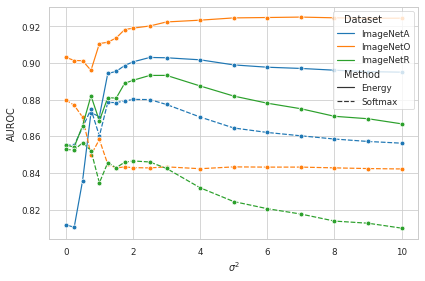

In [31]:
df = pd.concat(dfs)
df.rename(columns = {"Variance": "$\sigma^2$"}, inplace = True)
d = df.groupby(["$\sigma^2$", "Dataset", "Method"]).mean()

# d["$\sigma^2$"] = d["Variance"]
sb.lineplot(data=d, x="$\sigma^2$", y="AUROC", hue="Dataset", style="Method", marker="o")
# plt.title("ViT")
plt.tight_layout()
plt.savefig("img/imagenet-trans-auroc-vs-variance.png", dpi=300)
plt.savefig("img/imagenet-trans-auroc-vs-variance.pgf")
df.to_csv("results/imagenet-trans-auroc-vs-variance.csv")

In [21]:
df = pd.concat(dfs)

df = df[df["Variance"] == 2.0]
# df.groupby("Method").mean()
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration &  Variance \\
Method  &        &          &           &           &           &            &           \\
\midrule
Energy  &  90.34 &    62.16 &     96.76 &     67.68 &     39.47 &   99900.00 &    200.00 \\
Softmax &  85.65 &    53.57 &     95.33 &     54.24 &     55.31 &   99900.00 &    200.00 \\
\bottomrule
\end{tabular}



In [22]:
d

AUROC   AUPR-IN  AUPR-OUT  ACC95TPR  \
$\sigma^2$ Dataset   Method                                            
0.0        ImageNetA Energy   0.811748  0.338904  0.966031  0.520296   
                     Softmax  0.855323  0.471625  0.973294  0.545437   
           ImageNetO Energy   0.903127  0.429867  0.994872  0.557462   
                     Softmax  0.879862  0.381769  0.993498  0.502058   
           ImageNetR Energy   0.855252  0.775225  0.903317  0.639650   
...                                ...       ...       ...       ...   
10.0       ImageNetA Softmax  0.856242  0.499444  0.973714  0.559391   
           ImageNetO Energy   0.924451  0.552155  0.996059  0.642654   
                     Softmax  0.842178  0.324000  0.991507  0.418558   
           ImageNetR Energy   0.866793  0.821907  0.902226  0.626538   
                     Softmax  0.809875  0.751021  0.862832  0.555050   

                              FPR95TPR  Iteration  
$\sigma^2$ Dataset   Method                        
0.0        ImageNetA Energy    0.54396      999.0  
                     Softmax   0.51506      999.0  
           ImageNetO Energy    0.45824      999.0  
                     Softmax   0.51586      999.0  
           ImageNetR Energy    0.54656      999.0  
...                                ...        ...  
10.0       ImageNetA Softmax   0.49902      999.0  
           ImageNetO Energy    0.36964      999.0  
                     Softmax   0.60270      999.0  
           ImageNetR Energy    0.56754      999.0  
                     Softmax   0.68192      999.0  

[108 rows x 6 columns]

In [23]:
dfs_v2 = train(2.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

AUROC 999 -> 89.009%


In [24]:
df = pd.DataFrame(dfs_v2)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  90.30 &    62.04 &     96.74 &     67.61 &     39.57 &   99900.00 \\
Softmax &  85.62 &    53.37 &     95.32 &     54.42 &     55.11 &   99900.00 \\
\bottomrule
\end{tabular}



In [25]:
df

,AUROC,AUPR-IN,AUPR-OUT,ACC95TPR,FPR95TPR,Dataset,Iteration,Method
0,0.880068,0.544410,0.978448,0.597112,0.45566,ImageNetA,999,Softmax
1,0.900245,0.542860,0.983225,0.700757,0.33652,ImageNetA,999,Energy
2,0.842565,0.258627,0.991574,0.439846,0.58056,ImageNetO,999,Softmax
3,0.918521,0.467750,0.995921,0.654673,0.35714,ImageNetO,999,Energy
4,0.845949,0.797945,0.889470,0.595513,0.61718,ImageNetR,999,Softmax
5,0.890091,0.850567,0.923164,0.672850,0.49344,ImageNetR,999,Energy


# Evaluate model without additional training 

In [26]:
# in test set 
from pytorch_ood.utils import is_known
from torchmetrics import Accuracy

dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

# ood test sets 
imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)

imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)


model = VisionTransformer(image_size=(224, 224), pretrained="b16-im21k-224", num_classes=1000)
model._from_pretrained("b16-im21k-224")

model = model.cuda()

perf_metrics = []

print(f"Evaluating... ")
model.eval()
with torch.no_grad():
    
    acc = Accuracy()
    for x, y in test_in_loader:
        logits = model(x.cuda())
        acc.update(logits.cpu(), y)
        
    print(f"Accuracy: {acc.compute()}")

    softmax = MaxSoftmax(model)
    energy = EnergyBased(model)

    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_a_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)
    

    
    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetA",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetA",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)


    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_o_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)

    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetO",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetO",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)

    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_r_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)

    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetR",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetR",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)

    # print(f"AUROC {i} -> {m['AUROC']:.3%}")
    current_auroc = m['AUROC']

Evaluating... 
Accuracy: 0.8032799959182739


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [27]:
df = pd.DataFrame(perf_metrics)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  88.71 &    61.91 &     95.69 &     61.84 &     47.01 &       0.00 \\
Softmax &  82.48 &    50.38 &     93.92 &     49.56 &     61.34 &       0.00 \\
\bottomrule
\end{tabular}



# Train on noise 

In [28]:
from pytorch_ood.dataset.img import UniformNoise

def train_noise(outlier_set=10, iters=1000):
    dataset_out_train = UniformNoise(length=80000, size=(224,224,3), 
                                     target_transform=ToUnknown(), transform=preprocess)
    train_out_loader = DataLoader(dataset_out_train, batch_size=64, num_workers=20, shuffle=True)

    dataset_in_train = ImageNet(split="train", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    imagenet_in_loader = DataLoader(dataset_in_train, batch_size=64, num_workers=20, shuffle=True)

    # in test set 
    dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

    # ood test sets 
    imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)
    
    imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

    imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)
    
    
    model = VisionTransformer(image_size=(224, 224), pretrained="b16-im21k-224", num_classes=1000) # resnet101(pretrained=True)
    model._from_pretrained("b16-im21k-224")
    model = model.cuda()

    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []
    perf_metrics = []

    current_auroc = None 

    it_train_in = iter(imagenet_in_loader)
    it_train_out = iter(train_out_loader)

    criterion = OutlierExposureLoss()
    bar = tqdm.tqdm(range(iters))

    for i in bar:
        try:
            x1, y1 = next(it_train_in)
            x2, y2 = next(it_train_out)
        except Exception as e:
            print(e)
        except:
            it_train_in = iter(imagenet_in_loader)
            it_train_out = iter(train_out_loader)

        x = torch.cat([x1, x2])
        y = torch.cat([y1, y2])

        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        loss = criterion(y_hat, y)
        opti.zero_grad()
        loss.backward()
        opti.step()

        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        bar.set_postfix({"loss": mav, "AUROC": current_auroc})
    
    print(f"Evaluating... ")
    model.eval()
    with torch.no_grad():
        softmax = MaxSoftmax(model)
        energy = EnergyBased(model)
        
        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_a_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)
        

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_o_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_r_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        print(f"AUROC {i} -> {m['AUROC']:.3%}")
        current_auroc = m['AUROC']

    model.train()

    return perf_metrics


In [29]:
noise_metrics = train_noise()

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 85.334%


In [30]:
df = pd.DataFrame(noise_metrics)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  88.87 &    62.66 &     95.58 &     62.91 &     46.05 &   99900.00 \\
Softmax &  82.78 &    50.93 &     93.89 &     50.25 &     60.63 &   99900.00 \\
\bottomrule
\end{tabular}

